In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
#import gensim
#from time import time

In [2]:
from sklearn.naive_bayes import  BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV


from sklearn import metrics
#from sklearn.pipeline import Pipeline

# Data:

In [3]:
df = pd.read_csv("labled_tweets.csv").iloc[:,1:] # så du ikke får dumme index med.
print(df.shape)
df.head()

(5099, 2)


,text,lacking_dem_pref
0,Getting closer and closer on the Tax Cut Bill....,0.0
1,"Things are going really well for our economy, ...",1.0
2,No American should be separated from their lov...,0.0
3,Great Army - Navy Game. Army wins 14 to 13 and...,0.0
4,.@daveweigel of the Washington Post just admit...,0.0


In [4]:
X = df.text
y = df.lacking_dem_pref
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Functions:

In [5]:
def roc_test(X, save_name = "roc_test.pdf", title = "some_title", model_names = "", clf = LogisticRegression()):
    """X should be a list of tuples, where each tuple contains X_train at [0] and X_test at [1]"""
    plt.figure(figsize=[8,8])
    count = 0
    
    for i in X:
        clf_fit = clf.fit(i[0], y_train)
        pred_proba = clf_fit.predict_proba(i[1])[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba)
        auc = round(metrics.roc_auc_score(y_test, pred_proba), 3)
        plt.plot(fpr, tpr, label = model_names[count] + "AUC = " + str(auc))
        count +=1

    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    
    
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.title(title, fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize = 18)
    plt.grid(True)

    plt.legend(fontsize = 16)
    sns.despine(left=True, bottom= True)

    plt.savefig(save_name, bbox_inches="tight")
    plt.show()

# Prepros:

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set (nltk.corpus.stopwords.words("english"))
punct_n_sym = [".",":","...",",",";","@","'","''","``","’","“","*","!","?","(",")",
               "rt","https","http","#","-","&","a","i","w/","it","in","amp","n't","'s","goptaxscam","wa","ha"]

In [7]:
wordlist = []

def prep(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    wordlist = [w for w in wordlist if w not in stop_words and w not in punct_n_sym]

    return wordlist

In [8]:
vectorizer = CountVectorizer(tokenizer=prep) # count -> giver dig den højste F1 ind til vidre.
X_train_dtm = vectorizer.fit_transform(X_train) # dmt: document-term matrix
X_test_dtm = vectorizer.transform(X_test)

# Predictions

In [9]:
clf2 = BernoulliNB() # Brug den her istedet for MNB!!!!
clf3 = LogisticRegression() # den her
clf4 = SGDClassifier()
clf5 = LinearSVC() # Omitted du to no predict proba
clf6 = RandomForestClassifier()

In [10]:
alpha_range = np.arange(0.00001, 0.0001 , 0.000005)
    
param_grid = dict(alpha = alpha_range) 
grid = GridSearchCV(clf2, param_grid, cv=8, scoring="f1", n_jobs = -1) # Bernoulli NB

grid.fit(X_train_dtm ,y_train)

best_alpha = grid.best_params_["alpha"]


clf2 = BernoulliNB(alpha=best_alpha) # hentet fra overstående gridS.b

In [11]:
weight_range = [{1:1},{1:1.5},{1:2},{1:2.5},{1:3},{1:3.5},{1:4},{1:4.5},{1:5},{1:5.25},{1:5.5},{1:5.75},{1:6}]    
    
param_grid = dict(class_weight = weight_range) 
grid = GridSearchCV(clf3, param_grid, cv=8, scoring="f1", n_jobs = -1) # clf3 = LogisticRegression

grid.fit(X_train_dtm ,y_train) #

best_weight = grid.best_params_["class_weight"]


clf3 = LogisticRegression(class_weight= best_weight) # hentet fra overstående gridS.

In [12]:

weight_range = [{1:1},{1:1.5},{1:1.55},{1:1.6},{1:1.65},{1:1.7},{1:1.75},{1:1.8},{1:1.85},{1:2},{1:2.5}]    
alpha_range = np.arange(0.00001, 0.0001 , 0.000005)
    
param_grid = dict(alpha = alpha_range, class_weight = weight_range) 
grid = GridSearchCV(clf4, param_grid, cv=8, scoring="f1", n_jobs = -1) # clf4 = SGD Classifier

grid.fit(X_train_dtm ,y_train) #

best_alpha = grid.best_params_["alpha"]

best_weight = grid.best_params_["class_weight"]

clf4 = SGDClassifier(alpha=best_alpha, class_weight= best_weight, loss = "log", random_state= 42) 

/home/polichinel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/polichinel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/po

In [13]:
# omitted due to no predict proba

# weight_range = [{1:1},{1:1.5},{1:2},{1:2.25},{1:2.5},{1:2.75},{1:3},{1:3.5},{1:4},{1:4.5},{1:5},{1:5.5},{1:6}]    
    
# param_grid = dict(class_weight = weight_range) 
# grid = GridSearchCV(clf5, param_grid, cv=8, scoring="f1", n_jobs = -1) #  clf5 = LinearSVC

# grid.fit(X_train_dtm ,y_train)

# best_weight = grid.best_params_["class_weight"]

# clf5 = LinearSVC(class_weight= best_weight) # hentet fra overstående gridS.

In [14]:
weight_range = [{1:1},{1:1.5},{1:2},{1:2.25},{1:2.5},{1:2.75},{1:3},{1:3.5},{1:4},{1:4.5},{1:5},{1:5.5},{1:6}]    
    
param_grid = dict(class_weight = weight_range) 
grid = GridSearchCV(clf6, param_grid, cv=8, scoring="f1", n_jobs = -1) # clf6 = SGD RF classifier

grid.fit(X_train_dtm ,y_train)

best_weight = grid.best_params_["class_weight"]

clf6 = RandomForestClassifier(class_weight= best_weight, random_state= 42)

In [15]:
clfV = VotingClassifier(estimators=[("1",clf2),("2",clf3),("3",clf4),("4",clf6)],n_jobs=1) # seems to be the best..


In [16]:
test=clfV.fit(X_train_dtm, y_train)
y_pred_class = test.predict(X_test_dtm)


print("Confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred_class))

print("\n")

print("Train vs. test scores: ")
print('acc: ',metrics.accuracy_score(y_test, y_pred_class))
print('recall: ',metrics.recall_score(y_test, y_pred_class))
print('prec: ',metrics.precision_score(y_test, y_pred_class))
print('f1: ',metrics.f1_score(y_test, y_pred_class))

# Det kan faktisk godt være den giver lidt...

/home/polichinel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Confusion matrix: 
[[1128   12]
 [  72   63]]


Train vs. test scores: 
acc:  0.9341176470588235
recall:  0.4666666666666667
prec:  0.84
f1:  0.6000000000000001


/home/polichinel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


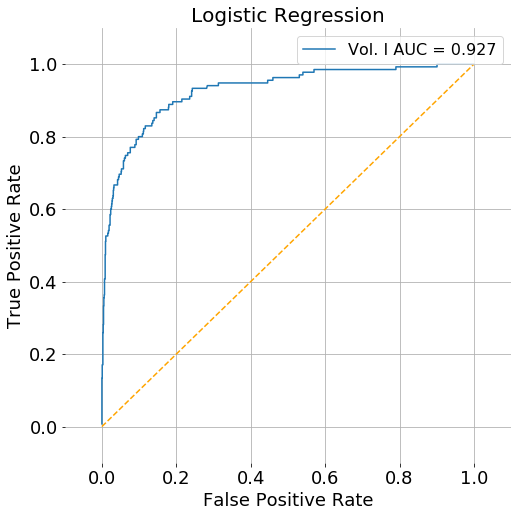

In [17]:
clf_log = LogisticRegression() # den her

model_names = ["Vol. I "]
roc_test([(X_train_dtm, X_test_dtm)], title= "Logistic Regression", save_name="vol_1_lg_roc.pdf", model_names=model_names, clf = clf_log)



/home/polichinel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


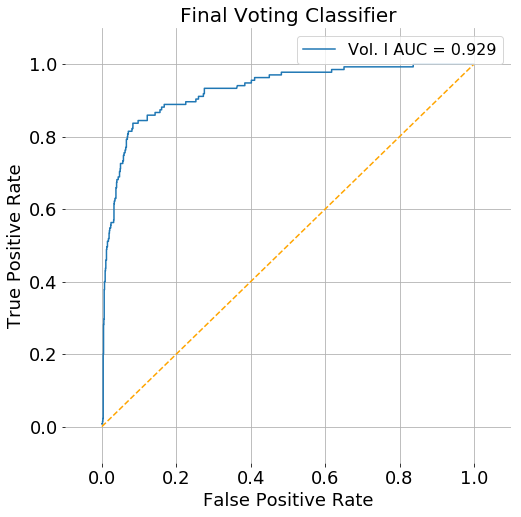

In [18]:
clfV = VotingClassifier(estimators=[("1",clf2),("2",clf3),("3",clf4),("4",clf6)], voting = "soft",n_jobs=1) # seems to be the best..

model_names = ["Vol. I "]
roc_test([(X_train_dtm, X_test_dtm)], title= "Final Voting Classifier", save_name="vol_1_vc_roc.pdf", model_names=model_names, clf = clfV)

